#<font color="red">Download Dataset</font>

In [4]:
!pip install jcopdl gdown
!pip install jcopdl==1.1.10
!gdown https://drive.google.com/uc?id=1KaiwyyYRGW8FbvSd4Feg1i1YW2k2s30u
!unzip /content/celebA_redux.zip

Streaming output truncated to the last 5000 lines.
  inflating: celebA_redux/train/005787.png  
  inflating: __MACOSX/celebA_redux/train/._005787.png  
  inflating: celebA_redux/train/004499.png  
  inflating: __MACOSX/celebA_redux/train/._004499.png  
  inflating: celebA_redux/train/007190.png  
  inflating: __MACOSX/celebA_redux/train/._007190.png  
  inflating: celebA_redux/train/000827.png  
  inflating: __MACOSX/celebA_redux/train/._000827.png  
  inflating: celebA_redux/train/006701.png  
  inflating: __MACOSX/celebA_redux/train/._006701.png  
  inflating: celebA_redux/train/009432.png  
  inflating: __MACOSX/celebA_redux/train/._009432.png  
  inflating: celebA_redux/train/000370.png  
  inflating: __MACOSX/celebA_redux/train/._000370.png  
  inflating: celebA_redux/train/010163.png  
  inflating: __MACOSX/celebA_redux/train/._010163.png  
  inflating: celebA_redux/train/004116.png  
  inflating: __MACOSX/celebA_redux/train/._004116.png  
  inflating: celebA_redux/train/003679.p

#<font color="red">Check Version JCOPDL</font>

In [7]:
import jcopdl
jcopdl.__version__

'1.1.10'

#<font color="red">Import Pytorch and Check Accelerator</font>

In [8]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

#<font color="red">Dataset and Data Loader</font>

In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

bs = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # menjadi (-1, 1)
])

train_set = datasets.ImageFolder("/content/celebA_redux", transform=transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#<font color="red">Architecture & Configuration</font>

In [10]:
%%writefile model_wdcgan.py
import torch
from torch import nn
from jcopdl.layers import conv_block, tconv_block, linear_block

def conv(c_in, c_out, batch_norm=True, activation="lrelu"):
    return conv_block(c_in, c_out, kernel=4, stride=2, pad=1, bias=False, batch_norm=batch_norm, activation=activation, pool_type=None)

def tconv(c_in, c_out, batch_norm=True, activation="lrelu"):
    return tconv_block(c_in, c_out, kernel=4, stride=2, pad=1, bias=False, batch_norm=batch_norm, activation=activation, pool_type=None)


class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv(3, 32, batch_norm=False),
            conv(32, 64),
            conv(64, 128),
            conv(128, 256),
            conv_block(256, 1, kernel=4, stride=1, pad=0, bias=False, activation=None, pool_type=None),
            nn.Flatten()
        )

    def forward(self, x):
        x = self.conv(x)
        return x

    def clip_weights(self, vmin=-0.01, vmax=0.01):
        for p in self.parameters():
            p.data.clamp_(vmin, vmax)


class Generator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.tconv = nn.Sequential(
            tconv_block(z_dim, 512, kernel=4, stride=2, pad=1, bias=False, activation="lrelu", pool_type=None),
            tconv(512, 256),
            tconv(256, 128),
            tconv(128, 64),
            tconv(64, 32),
            tconv(32, 3, activation="tanh", batch_norm=False)
        )

    def forward(self, x):
        return self.tconv(x)

    def generate(self, n, device):
        z = torch.randn((n, self.z_dim, 1, 1), device=device)
        return self.tconv(z)

Overwriting model_wdcgan.py


#<font color="red">Config Data Dictionary</font>

In [11]:
config = set_config({
    "z_dim": 100,
    "batch_size": bs
})

#<font color="red">Training Preparation</font>

###<font color="red">Import Model from py File</font>

In [12]:
from model_wdcgan import Critic, Generator

###<font color="red">Define Wasserstein Loss Function</font>

In [13]:
def wasserstein_loss(output, target):
    return output.mean() * target.mean()


###<font color="red">Create Model, Criterion, and their Optimizer</font>

In [14]:
D = Critic().to(device)
G = Generator(config.z_dim).to(device)

criterion = wasserstein_loss

d_optimizer = optim.RMSprop(D.parameters(), lr=1e-4)
g_optimizer = optim.RMSprop(G.parameters(), lr=1e-4)

#<font color="red">Training Phase</font>

In [15]:
import os
from torchvision.utils import save_image
from tqdm.auto import tqdm

os.makedirs("output/WDCGAN/", exist_ok=True)
os.makedirs("model/WDCGAN/", exist_ok=True)

In [16]:
max_epochs = 1000
for epoch in range(max_epochs):
    D.train()
    G.train()
    for i, (real_img, _) in enumerate(trainloader):
        n_data = real_img.shape[0]
        ## Real and Fake Images
        real_img = real_img.to(device)
        fake_img = G.generate(n_data, device)

        ## Real and Fake Labels
        real = -torch.ones((n_data, 1), device=device)
        fake = torch.ones((n_data, 1), device=device)

        ## Training Discriminator ##
        d_optimizer.zero_grad()
        # Real image -> Discriminator -> label Real
        output = D(real_img)
        d_real_loss = criterion(output, real)

        # Fake image -> Discriminator -> label Fake
        output = D(fake_img.detach())
        d_fake_loss = criterion(output, fake)

        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        # Weight clipping
        D.clip_weights()

        if i % 5 == 0:
            ## Training Generator ##
            g_optimizer.zero_grad()
            # Fake image -> Discriminator -> label Real
            output = D(fake_img)
            g_loss = criterion(output, real)
            g_loss.backward()
            g_optimizer.step()


    if epoch % 5 == 0:
        print(f"Epoch: {epoch:5} | D_loss: {d_loss/2:.5f} | G_loss: {g_loss:.5f}")

    if epoch % 15 == 0:
        G.eval()
        epoch = str(epoch).zfill(4)
        fake_img = G.generate(64, device)
        save_image(fake_img, f"output/WDCGAN/{epoch}.jpg", nrow=8, normalize=True)

        torch.save(D, "model/WDCGAN/critic.pth")
        torch.save(G, "model/WDCGAN/generator.pth")

Epoch:     0 | D_loss: -0.22126 | G_loss: 0.23619
Epoch:     5 | D_loss: -0.27831 | G_loss: 0.34119
Epoch:    10 | D_loss: -0.19286 | G_loss: 0.33181
Epoch:    15 | D_loss: -0.29097 | G_loss: 0.32549
Epoch:    20 | D_loss: -0.24533 | G_loss: 0.26270
Epoch:    25 | D_loss: -0.23073 | G_loss: 0.31593
Epoch:    30 | D_loss: -0.18745 | G_loss: 0.29257
Epoch:    35 | D_loss: -0.20949 | G_loss: 0.28075
Epoch:    40 | D_loss: -0.17018 | G_loss: 0.19803
Epoch:    45 | D_loss: -0.14158 | G_loss: 0.26598
Epoch:    50 | D_loss: -0.14325 | G_loss: 0.04253
Epoch:    55 | D_loss: -0.14781 | G_loss: 0.09504
Epoch:    60 | D_loss: -0.11102 | G_loss: 0.06913
Epoch:    65 | D_loss: -0.12716 | G_loss: 0.07664
Epoch:    70 | D_loss: -0.10448 | G_loss: 0.05421
Epoch:    75 | D_loss: -0.11381 | G_loss: -0.01205
Epoch:    80 | D_loss: -0.11823 | G_loss: 0.17693
Epoch:    85 | D_loss: -0.11610 | G_loss: 0.20253
Epoch:    90 | D_loss: -0.11810 | G_loss: 0.04516
Epoch:    95 | D_loss: -0.10781 | G_loss: 0.19857

KeyboardInterrupt: ignored

#<font color="red">Test Create Fake Image from Model</font>

In [20]:
import torch
from torchvision.utils import save_image
import os
from IPython.display import Image

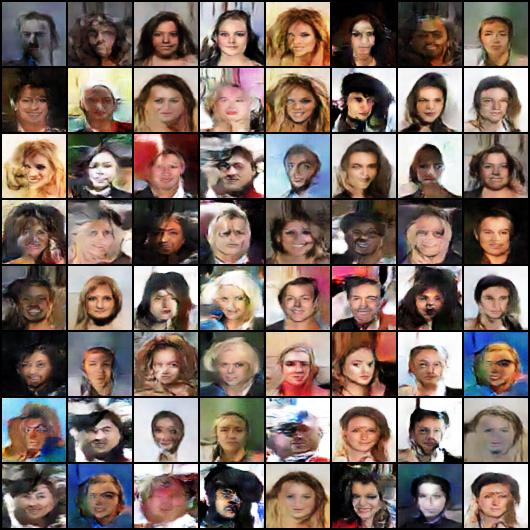

In [27]:
model="WDCGAN"
G = torch.load(f"model/{model}/generator.pth").eval()
fake_img = G.generate(64, device)
save_image(fake_img, f"output/{model}.jpg", nrow=8, normalize=True)
Image(f"output/{model}.jpg")